In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astropy.io import fits
from astropy.io import ascii

In [2]:
from astroplan.plots import plot_airmass
from astroplan import Observer
from astroplan import FixedTarget
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
from astroplan import is_observable, is_always_observable, months_observable
observer = Observer.at_site('palomar')
from astroplan import EclipsingSystem

In [3]:
lightcurve = Table.from_pandas(pd.read_csv("light_curve_dd8451da-93c0-4273-bdb0-8000aaf97339.csv"))
lightcurve_ztf = Table.from_pandas(pd.read_csv("table_httpsirsa.ipac.caltech.educgi-bing2pnp.csv"))

In [4]:
filters = np.unique(lightcurve["Camera"])

In [5]:
lightcurve[0]

HJD,UT Date,Camera,FWHM,Limit,mag,mag_err,flux(mJy),flux_err,Filter
float64,str18,str2,float64,float64,str7,float64,float64,float64,str1
2459761.80707,2022-07-01.3012961,bF,1.46,16.619,14.245,0.025,7.285,0.166,g


In [6]:
lightcurve_filtered = []
for i in filters:
    lightcurve_filtered.append(lightcurve[np.where(lightcurve["Camera"] == i)])

In [7]:
for i in lightcurve_filtered:
    print(len(i))

51
75
66
74


In [8]:
from astropy.timeseries import LombScargle

In [9]:
row = lightcurve_ztf
hjd = np.array(row["mjd"])
hjd = hjd.astype("float")
hjd = hjd * u.day
mag = np.array(row["mag"])
for i in range(len(mag)):
    if(">" in str(mag[i])):
        mag[i] = mag[i][1:-1]
mag = np.asarray(mag)
mag = mag.astype("float")
mag = mag * u.mag
mag_err = np.array(row["magerr"])
mag_err = mag_err.astype("float")
mag_err = mag_err * u.mag

In [10]:
ztf_period = 0.110375275900
ztf_frequency = 1/ztf_period
ztf_frequency

9.06000000313476

In [11]:
ideal_frequency = np.linspace(4, 7, 10**7) * (1/u.day)

In [12]:
power = LombScargle(hjd, mag , mag_err).power(ideal_frequency)

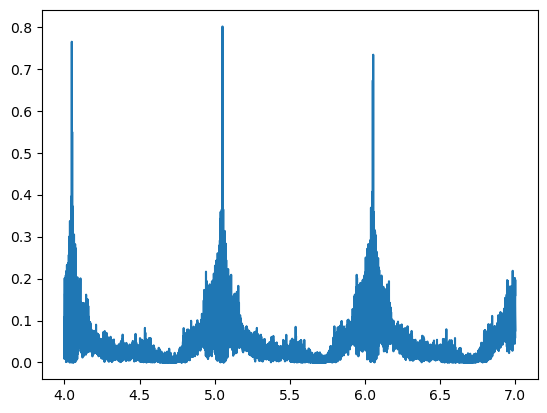

In [13]:
plt.plot(ideal_frequency, power)
#plt.vlines(ztf_frequency, 0, np.max(power), color = "red")

In [14]:
ztf_f = ideal_frequency[np.argmax(power)]
ztf_p = 1/ztf_f
ztf_p

<Quantity 0.19794614 d>

Text(0, 0.5, 'R Mag')

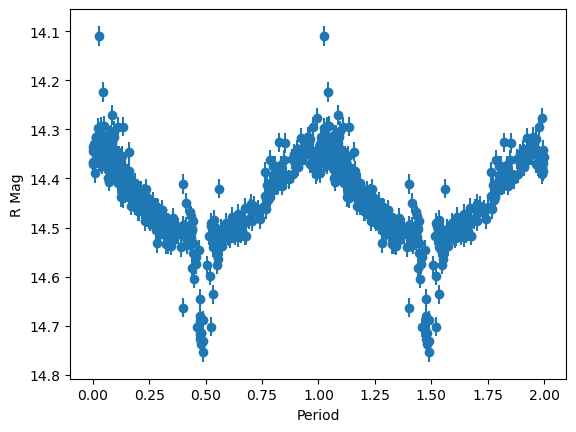

In [15]:
hjd_p_fold = hjd % ztf_p / ztf_p
hjd_p_fold = np.append(hjd_p_fold, 1 + hjd_p_fold)
mag_p_fold = np.append(mag, mag)
mag_err_p_fold = np.append(mag_err, mag_err)
plt.errorbar(hjd_p_fold, mag_p_fold, mag_err_p_fold, fmt = "o")
#plt.xlim(0.4,0.55)
#plt.ylim(14.4, 14.8)
plt.gca().invert_yaxis()

plt.xlabel("Period")
plt.ylabel("R Mag")

In [16]:
folded = hjd % ztf_p / ztf_p

In [17]:
eclipsing = lightcurve_ztf[np.where(lightcurve_ztf["mag"] > 14.7)]

In [18]:
eclipsing[np.where((eclipsing["mjd"] < 58723) & (eclipsing["mjd"] > 58721))]

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
int64,int64,float64,float64,float64,float64,int64,str2,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64
334215200022630,96820172,2458722.705514448,58722.2017245,14.716828,0.01974558,0,zr,282.4644578,-13.676206,1.12800002,-0.0719999969,20190827201655,334,15,2,20.4599991,26.142416,0.026071195,0.06766316,1.2111449e-05,30.0,1.579,2
334215200022630,96820217,2458722.7059658137,58722.2021759,14.714024,0.01974614,32768,zr,282.4644591,-13.6761967,1.18400002,-0.0700000003,20190827202176,334,15,2,20.4699993,26.129602,0.025107626,0.07229456,1.11314057e-05,30.0,1.579,2
334215200022630,96820262,2458722.706417179,58722.2026273,14.715215,0.0197459,0,zr,282.4644555,-13.6762046,1.16900003,-0.0240000002,20190827202627,334,15,2,20.4799995,26.157797,0.029082041,0.07499938,1.50683827e-05,30.0,1.58000004,2


In [19]:
eclipsing = lightcurve_ztf[np.argmax(lightcurve_ztf["mag"])]
eclipsing

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
int64,int64,float64,float64,float64,float64,int64,str2,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64
334215200022630,96424534,2458718.749430737,58718.2453472,14.75384,0.01973894,0,zr,282.4644882,-13.6762249,0.95300001,0.0160000008,20190823245289,334,15,2,20.4899998,26.183104,0.030723449,0.06566177,1.70312105e-05,30.0,1.67499995,2


In [20]:
primary_eclipse_time = Time(eclipsing["mjd"], format='mjd')
orbital_period = ztf_p
eclipse_duration = 0.08 * ztf_p

In [21]:
J184951 = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                           orbital_period=orbital_period, duration=eclipse_duration,
                           name='J184951')
np.save("J184951", np.array([J184951]))

In [22]:
observing_time = Time('2023-05-05 8:00')
J184951.next_primary_eclipse_time(observing_time, n_eclipses = 8)

<Time object: scale='utc' format='iso' value=['2023-05-05 10:12:59.422' '2023-05-05 14:58:01.968'
 '2023-05-05 19:43:04.514' '2023-05-06 00:28:07.061'
 '2023-05-06 05:13:09.607' '2023-05-06 09:58:12.153'
 '2023-05-06 14:43:14.700' '2023-05-06 19:28:17.246']>

In [23]:
J184951.next_secondary_eclipse_time(observing_time, n_eclipses = 8)

<Time object: scale='utc' format='iso' value=['2023-05-05 12:35:30.695' '2023-05-05 17:20:33.241'
 '2023-05-05 22:05:35.787' '2023-05-06 02:50:38.334'
 '2023-05-06 07:35:40.880' '2023-05-06 12:20:43.427'
 '2023-05-06 17:05:45.973' '2023-05-06 21:50:48.519']>